In [1]:
import os
import re
import time
import pickle
import shutil
import numpy as np
import pandas as pd
import xlwings as xw
from fcsparser import parse
import matplotlib.pyplot as plt
from matplotlib.path import Path
from openpyxl import load_workbook
from matplotlib.patches import Polygon
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
def remove_outliers_percentile(df, columns=None, lower_quantile=0.0025, upper_quantile=0.99):
    """
    Удаляет выбросы в датафрейме df, обрезая значения за заданными перцентилями.
    
    Параметры:
    ----------
    df : pd.DataFrame
        Исходный датафрейм.
    columns : list or None
        Список столбцов, по которым ищем выбросы.
        Если None, то берём все числовые столбцы.
    lower_quantile : float
        Нижняя граница (от 0 до 1), по умолчанию 0.0025 (0.25%).
    upper_quantile : float
        Верхняя граница (от 0 до 1), по умолчанию 0.99 (99%).
    
    Возвращает:
    -----------
    pd.DataFrame
        Датафрейм без выбросов.
    """
    
    # Если столбцы не указаны, берём все числовые
    if columns is None:
        columns = df.select_dtypes(include='number').columns.tolist()
    
    # Создадим копию, чтобы не менять исходный датафрейм
    df_clean = df.copy()
    
    for col in columns:
        if col not in df_clean.columns:
            # Если в списке оказался столбец, которого нет в датафрейме
            continue
        
        # Вычислим перцентили
        low_val = df_clean[col].quantile(lower_quantile)
        high_val = df_clean[col].quantile(upper_quantile)
        
        # Фильтруем выбросы
        df_clean = df_clean[(df_clean[col] >= low_val) & (df_clean[col] <= high_val)]
    
    return df_clean

In [3]:
def log_arcsinh_transform_data(data, cofactor_mapping=None):
    """
    Применяет преобразования к датафрейму.
    
    Для столбцов, в названии которых встречается одно из ключевых слов 
    ('CD'), применяется arcsinh-преобразование с заданным ко-фактором.
    Для остальных столбцов выполняется клиппинг (чтобы избежать log(0)) и логарифмирование.
    
    Параметры:
    ----------
    data : pd.DataFrame
        Исходный датафрейм.
    cofactor_mapping : dict, optional
        Словарь, сопоставляющий ключевые слова и их ко-факторы.
        По умолчанию: {'CD': 5}
    
    Возвращает:
    -----------
    pd.DataFrame
        Датафрейм после преобразований.
    """
    if cofactor_mapping is None:
        cofactor_mapping = {'CD': 3, 'Ig': 3}  # хорошие: 5
    
    data_transformed = data.copy()
    
    for col in data_transformed.columns:
        # Если имя столбца содержит одно из ключевых слов,
        # применяем arcsinh-преобразование с соответствующим ко-фактором.
        applied_arcsinh = False
        for key, cofactor in cofactor_mapping.items():
            if key in col:
                data_transformed[col] = np.arcsinh(data_transformed[col] / cofactor)
                applied_arcsinh = True
                break  # Если нашли соответствие, дальнейшие проверки не требуются.
                
        # Если столбец не содержит заданных ключевых слов, применяем стандартное преобразование:
        if not applied_arcsinh:
            # Клиппинг для предотвращения log(0)
            data_transformed[col] = data_transformed[col].clip(lower=1)
            # Логарифмирование по основанию 2
            data_transformed[col] = np.log2(data_transformed[col])
            
    return data_transformed

In [4]:
def process_test_data(path, tube, pdf=False, fcs_del=True):
    reports_dir = os.path.join(path, "Reports")
    os.makedirs(reports_dir, exist_ok=True)  # Создаём папку Reports в path

    saved_path = os.path.join(path, "Examples", "Saved_UMAP_n_csv")  # Исправленный путь к классификатору

    # Обходим все папки в корневом каталоге, исключая служебные папки
    for folder_name in sorted(os.listdir(path)):
        if folder_name in ["Reports", "Examples"]:
            continue

        folder_path = os.path.join(path, folder_name)
        if not os.path.isdir(folder_path):
            continue

        # Собираем файлы по порядку tube
        ordered_files = []
        for tube_item in tube:
            tube_prefix = tube_item.split('.')[0]
            files_for_prefix = [f for f in os.listdir(folder_path) if tube_prefix in f and f.endswith(".fcs")]
            ordered_files.extend(files_for_prefix)

        if not ordered_files:
            continue  # Пропускаем папку, если нет подходящих .fcs файлов

        pdf_pages = None
        if pdf:
            pdf_path = os.path.join(reports_dir, f"Report of {folder_name}.pdf")
            pdf_pages = PdfPages(pdf_path)
            csv_path = os.path.join(reports_dir, f"Report_of_{folder_name}.csv")

        print(f"\nОбрабатываю папку: {folder_name}")
        for filename in ordered_files:
            file_path = os.path.join(folder_path, filename)

            # Определяем tube_prefix
            tube_prefix = None
            for tube_item in tube:
                prefix = tube_item.split('.')[0]
                if prefix in filename:
                    tube_prefix = prefix
                    break
            if tube_prefix is None:
                print(f"Префикс для файла {filename} не найден.")
                continue

            try:
                meta, data = parse(file_path)
                del meta
                if len(data) > 120_000:
                    data = data.sample(n=100_000, random_state=42)
                data = data.drop(columns=[col for col in data.columns if col.endswith(('-A', 'Width', 'Time'))])
                data_no_outliers = remove_outliers_percentile(data)
                data_normalized = log_arcsinh_transform_data(data_no_outliers)
            except Exception as e:
                print(f"Ошибка при обработке {filename}: {e}")
                continue

            classifier_file = None
            if os.path.isdir(saved_path):
                for clf in os.listdir(saved_path):
                    if clf.endswith(".pkl") and tube_prefix in clf:
                        classifier_file = os.path.join(saved_path, clf)
                        break
            if classifier_file is None:
                print(f"Классификатор для {tube_prefix} не найден в {saved_path}.")
                continue

            try:
                with open(classifier_file, "rb") as f:
                    reducer = pickle.load(f)
                umap_result = reducer.transform(data_normalized)
            except Exception as e:
                print(f"Ошибка при применении UMAP {filename}: {e}")
                continue

            umap_df = pd.DataFrame(umap_result, columns=[f'UMAP{i+1}' for i in range(reducer.n_components)])

            polygon_file = os.path.join(saved_path, f"polygons_{tube_prefix}.csv")
            if not os.path.exists(polygon_file):
                print(f"Файл с полигонами {polygon_file} не найден.")
                continue

            try:
                polygons_df = pd.read_csv(polygon_file)
            except Exception as e:
                print(f"Ошибка при загрузке полигонов {polygon_file}: {e}")
                continue

            # ---- Визуализация UMAP ----
            fig, ax = plt.subplots(figsize=(10, 8))
            ax.scatter(umap_df["UMAP1"], umap_df["UMAP2"], s=5, alpha=0.5, label="Data")

            umap_df_result = umap_df.copy()
            polygon_groups = {}
            added_legend_items = set()

            for (name, n) in polygons_df[["name", "n"]].drop_duplicates().itertuples(index=False):
                poly_data = polygons_df[(polygons_df["name"] == name) & (polygons_df["n"] == n)]
                polygon = np.array(list(zip(poly_data["x"], poly_data["y"])))
                poly_color = poly_data["color"].iloc[0]
                legend_key = (name, poly_color)
                poly_patch = Polygon(polygon, edgecolor=poly_color, facecolor="none", lw=2)
                ax.add_patch(poly_patch)
                if legend_key not in added_legend_items:
                    ax.plot([], [], color=poly_color, label=name)
                    added_legend_items.add(legend_key)
                path_obj = Path(polygon)
                inside = path_obj.contains_points(umap_df[["UMAP1", "UMAP2"]].values).astype(np.int32)
                if name in polygon_groups:
                    polygon_groups[name] |= inside
                else:
                    polygon_groups[name] = inside

            for name, inside_mask in polygon_groups.items():
                umap_df_result[name] = inside_mask

            ax.legend()
            plt.xlabel("UMAP1")
            plt.ylabel("UMAP2")
            plt.title(f"Тестовые данные: {filename}")

            # ---- Подготовка статистики ----
            stats = umap_df_result.describe().T.iloc[2:, :2]
            if "Trash" in umap_df_result.columns:
                total_cells = len(umap_df_result)
                trash_count = (umap_df_result["Trash"] == 1).sum()
                granulocytes_count = (umap_df_result["Granulocytes"] == 1).sum() if "Granulocytes" in umap_df_result.columns else 0
                mononuclears = total_cells - trash_count - granulocytes_count
                stats.loc["Mononuclears", ["count", "mean"]] = [mononuclears, mononuclears / total_cells * 100]
                if "Granulocytes" in umap_df_result.columns:
                    stats.loc["Granulocytes", ["count", "mean"]] = [granulocytes_count, granulocytes_count / (total_cells - trash_count) * 100]
                for pop in polygon_groups.keys():
                    if pop in umap_df_result.columns and pop not in ["Trash", "Granulocytes"]:
                        count = umap_df_result[pop].sum()
                        stats.loc[pop, ["count", "mean"]] = [count, count / mononuclears * 100]

            stats.columns = ['Абс. количество', 'Содержание, %']
            stats['Абс. количество'] = stats['Абс. количество'].astype(np.int32)
            stats['Содержание, %'] = stats['Содержание, %'].astype(np.float32).round(4)
            stats = stats.drop("Trash", errors="ignore")

            print(f"\nСтатистика для пробирки {filename} (пациент: {folder_name}):")
            plt.show()
            display(stats)
            plt.close(fig)

            if pdf and pdf_pages:
                png_path = os.path.join(reports_dir, f"{folder_name}_{filename}.png")
                fig.savefig(png_path, dpi=150, bbox_inches='tight')  # Сохраняем график в PNG
                img = plt.imread(png_path)
                fig_img, ax_img = plt.subplots(figsize=(10, 8))
                ax_img.imshow(img)
                ax_img.axis('off')  # Убираем оси
                pdf_pages.savefig(fig_img)  # Сохраняем изображение в PDF
                plt.close(fig_img)
                os.remove(png_path)  # Удаляем временный PNG-файл
                fig_table, ax_table = plt.subplots(figsize=(8, 4))
                ax_table.axis('tight')
                ax_table.axis('off')
                table_data = stats.reset_index().values.tolist()
                table_data.insert(0, ["Группа", "Абс. количество", "Содержание, %"])
                ax_table.table(cellText=table_data, loc="center", cellLoc="center")
                plt.title(f"Статистика для образца {folder_name}.")
                pdf_pages.savefig(fig_table)
                plt.close(fig_table)
            if pdf:
                stats.to_csv(csv_path, mode='a', header=not os.path.exists(csv_path))
                print(f"Отчёт сохранён в {csv_path}")

        if pdf and pdf_pages:
            pdf_pages.close()
            print(f"Отчёт сохранён в {pdf_path}")

        if fcs_del:
            shutil.rmtree(folder_path)
            print(f"Удалена папка: {folder_path}")

In [5]:
# Формирование отчёта, добавление хедера и футера
def make_report(path, blanks, coordinates, image_folder=None, clean=True):
    """
    Формирует отчёт, перенося данные из CSV в бланк XLSX.
    Перенос данных выполняется с сохранением форматирования ячеек.
    
    Если передана папка image_folder, то после переноса данных в файл будут добавлены:
      - hl.jpeg — левая часть заголовка (Header Left)
      - hr.jpeg — правая часть заголовка (Header Right)
      - fr.jpeg — правая часть нижнего колонтитула (Footer Right)
    
    Параметры:
      path         — корневая папка, где находится папка Reports с CSV-отчётами.
      blanks       — папка с шаблонами (бланками) XLSX.
      coordinates  — папка, где лежит файл Coordinates.xlsx с координатами.
      image_folder — (опционально) папка с изображениями для header/footer.
      clean        — если True, после формирования отчёта CSV-файл удаляется.
    """
    import os, re, time
    import pandas as pd
    from openpyxl import load_workbook
    import xlwings as xw

    # Папка с CSV-отчётами
    reports_folder = os.path.join(path, "Reports")
    report_files = [f for f in os.listdir(reports_folder) if f.endswith(".csv")]
    report_names = [f.replace("Report_of_", "").replace(".csv", "") for f in report_files]

    # Загружаем координаты
    coordinates_file = os.path.join(coordinates, "Coordinates.xlsx")
    df_coords = pd.read_excel(coordinates_file, index_col=None)

    # Если нужны изображения, готовим полные пути
    if image_folder is not None:
        left_header_img = os.path.join(image_folder, "hl.jpeg")
        right_header_img = os.path.join(image_folder, "hr.png")
        right_footer_img = os.path.join(image_folder, "fr.jpeg")

    for report_name in report_names:
        csv_path = os.path.join(reports_folder, f"Report_of_{report_name}.csv")
        matching_files = [f for f in os.listdir(blanks) if re.match(fr"^{re.escape(report_name)}.*\.xlsx$", f)]
        if not matching_files:
            continue

        xlsx_path = os.path.join(blanks, matching_files[0])
        if not os.path.exists(csv_path):
            continue

        # Загружаем CSV-данные
        df_report = pd.read_csv(csv_path, header=0)
        filter_value = df_report.iloc[0, 0]
        df_filtered = df_coords[df_coords["Col0str1_in_report"] == filter_value]
        if df_filtered.empty:
            continue

        # Открываем XLSX через openpyxl для переноса данных и сохранения форматирования
        wb = load_workbook(xlsx_path)
        ws = wb.active

        # Сохраняем размеры столбцов и строк
        column_widths = {col: ws.column_dimensions[col].width for col in ws.column_dimensions}
        row_heights = {row: ws.row_dimensions[row].height for row in ws.row_dimensions}

        # Перенос данных с форматированием: устанавливаем число с двумя знаками после запятой
        for _, row in df_filtered.iterrows():
            blank_cell = str(row["Data_in_blank_position"]).strip()
            if pd.isna(row["Data_in_report_position"]):
                ws[blank_cell] = 0
                ws[blank_cell].number_format = '0.00'
            else:
                report_index = int(row["Data_in_report_position"])
                if report_index < len(df_report):
                    value_to_copy = df_report.iloc[report_index, 2]
                    ws[blank_cell] = value_to_copy
                    ws[blank_cell].number_format = '0.00'

        # Восстанавливаем размеры ячеек
        for col, width in column_widths.items():
            ws.column_dimensions[col].width = width
        for row, height in row_heights.items():
            ws.row_dimensions[row].height = height

        # Сохраняем изменения и закрываем файл через openpyxl
        wb.save(xlsx_path)
        wb.close()

        # Если указан image_folder, открываем файл через xlwings для добавления header/footer
        if image_folder is not None:
            try:
                app = xw.App(visible=False)
                wb_xw = app.books.open(xlsx_path)
                sht = wb_xw.sheets[0]
                
                # Устанавливаем header/footer с картинками через Excel API:
                if os.path.exists(left_header_img):
                    sht.api.PageSetup.LeftHeaderPicture.Filename = left_header_img
                    sht.api.PageSetup.LeftHeader = "&G"
                if os.path.exists(right_header_img):
                    sht.api.PageSetup.RightHeaderPicture.Filename = right_header_img
                    sht.api.PageSetup.RightHeader = "&G"
                if os.path.exists(right_footer_img):
                    sht.api.PageSetup.RightFooterPicture.Filename = right_footer_img
                    sht.api.PageSetup.RightFooter = "&G"
                    
                wb_xw.save()
                wb_xw.close()
            except Exception as e:
                print(f"Ошибка при установке header/footer в файле {xlsx_path}: {e}")
            finally:
                app.quit()

        # Удаляем CSV, если clean=True
        if clean:
            os.remove(csv_path)

In [6]:
# path = r"C:\Users\vsemis\files\Flow_cyt_robot" # внимание комп
path = r"D:\NovoExpress Data"  # очередной комп
tube = [r"10_56_45_19_138_38.fcs", r"λ_κ_45_117_138_38.fcs", r"xx_79a_45_Ki67_3_xx.fcs"]


Обрабатываю папку: Бурылова Г.Н
Mon Apr 21 21:31:27 2025 Building and compiling search function


C:\Users\vsevo\flowcytlibs\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Epochs completed:   0%|            0/30 [00:00]

	completed  0  /  30 epochs
	completed  3  /  30 epochs
	completed  6  /  30 epochs
	completed  9  /  30 epochs
	completed  12  /  30 epochs
	completed  15  /  30 epochs
	completed  18  /  30 epochs
	completed  21  /  30 epochs
	completed  24  /  30 epochs
	completed  27  /  30 epochs

Статистика для пробирки 10_56_45_19_138_38.fcs (пациент: Бурылова Г.Н):


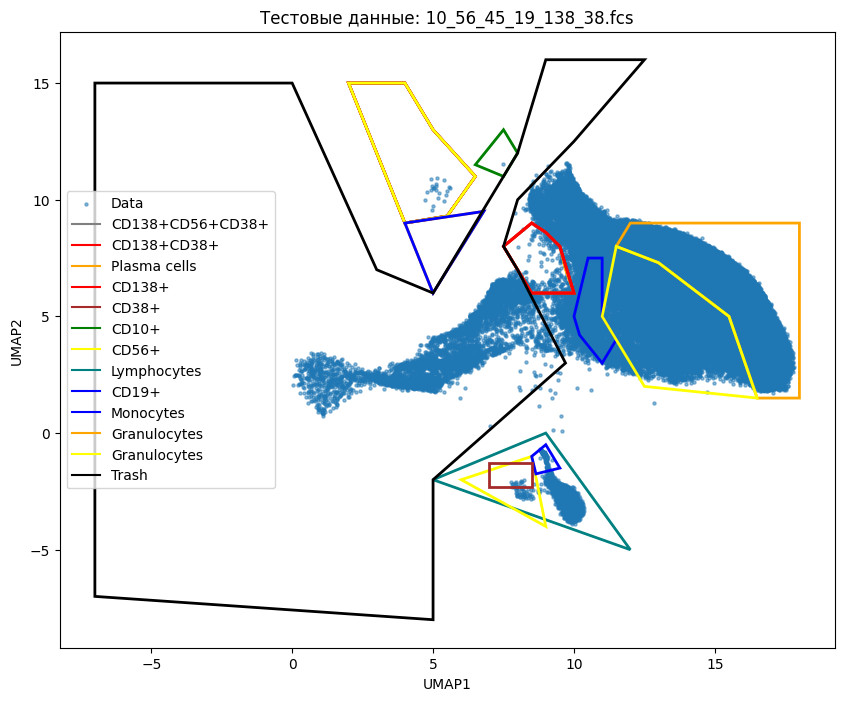

,Абс. количество,"Содержание, %"
CD138+CD56+CD38+,21,0.137600
CD138+CD38+,268,1.756300
Plasma cells,239,1.566300
CD138+,268,1.756300
CD38+,282,1.848100
CD10+,1,0.006600
CD56+,86,0.563600
Lymphocytes,2209,14.476700
CD19+,480,3.145700
Monocytes,2849,18.670900


Отчёт сохранён в D:\NovoExpress Data\Reports\Report_of_Бурылова Г.Н.csv
Mon Apr 21 21:33:33 2025 Building and compiling search function


C:\Users\vsevo\flowcytlibs\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Epochs completed:   0%|            0/30 [00:00]

	completed  0  /  30 epochs
	completed  3  /  30 epochs
	completed  6  /  30 epochs
	completed  9  /  30 epochs
	completed  12  /  30 epochs
	completed  15  /  30 epochs
	completed  18  /  30 epochs
	completed  21  /  30 epochs
	completed  24  /  30 epochs
	completed  27  /  30 epochs

Статистика для пробирки λ_κ_45_117_138_38.fcs (пациент: Бурылова Г.Н):


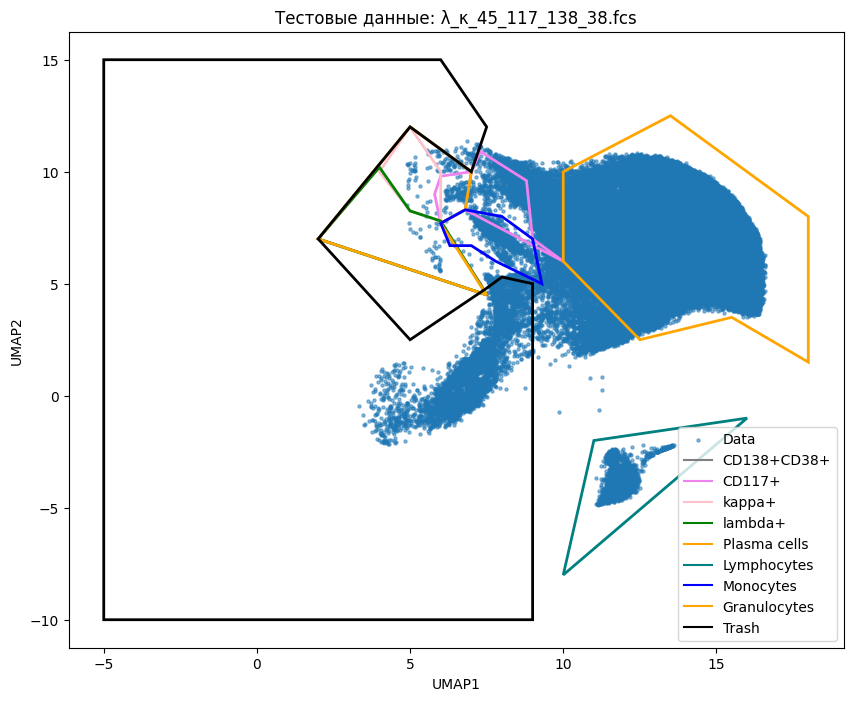

,Абс. количество,"Содержание, %"
CD138+CD38+,240,1.921200
CD117+,1761,14.097000
kappa+,38,0.304200
lambda+,41,0.328200
Plasma cells,239,1.913200
Lymphocytes,2042,16.346500
Monocytes,1635,13.088400
Granulocytes,54499,81.352699
Mononuclears,12492,17.532101


Отчёт сохранён в D:\NovoExpress Data\Reports\Report_of_Бурылова Г.Н.csv
Mon Apr 21 21:35:26 2025 Building and compiling search function


C:\Users\vsevo\flowcytlibs\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Epochs completed:   0%|            0/30 [00:00]

	completed  0  /  30 epochs
	completed  3  /  30 epochs
	completed  6  /  30 epochs
	completed  9  /  30 epochs
	completed  12  /  30 epochs
	completed  15  /  30 epochs
	completed  18  /  30 epochs
	completed  21  /  30 epochs
	completed  24  /  30 epochs
	completed  27  /  30 epochs

Статистика для пробирки xx_79a_45_Ki67_3_xx.fcs (пациент: Бурылова Г.Н):


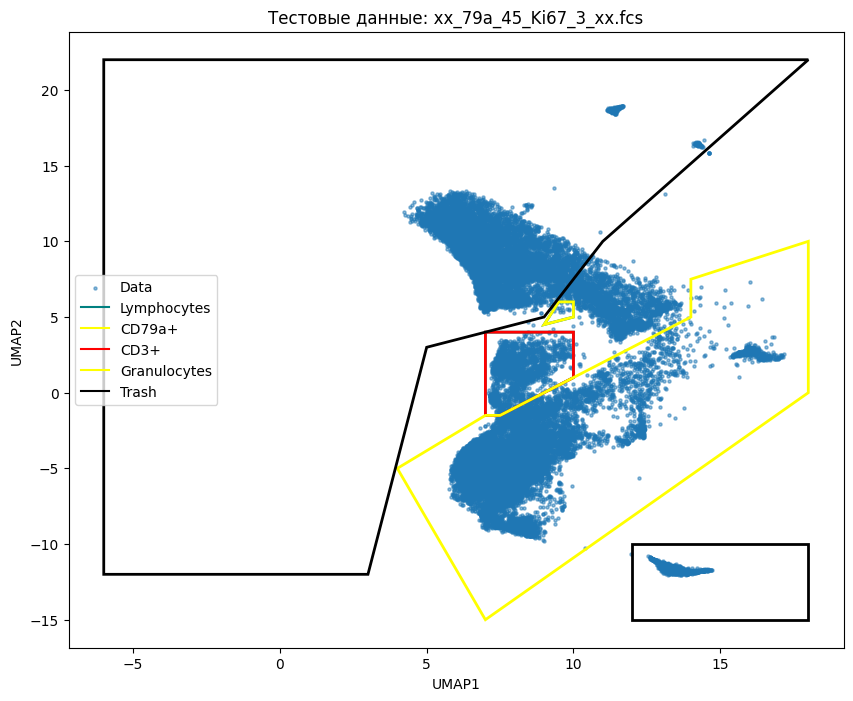

,Абс. количество,"Содержание, %"
Lymphocytes,2029,46.590099
CD79a+,15,0.344400
CD3+,2014,46.245701
Granulocytes,20025,82.137001
Mononuclears,4355,12.059700


Отчёт сохранён в D:\NovoExpress Data\Reports\Report_of_Бурылова Г.Н.csv
Отчёт сохранён в D:\NovoExpress Data\Reports\Report of Бурылова Г.Н.pdf
Удалена папка: D:\NovoExpress Data\Бурылова Г.Н

Обрабатываю папку: Мадрахимова Д.Х
Mon Apr 21 21:36:27 2025 Building and compiling search function


C:\Users\vsevo\flowcytlibs\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Epochs completed:   0%|            0/30 [00:00]

	completed  0  /  30 epochs
	completed  3  /  30 epochs
	completed  6  /  30 epochs
	completed  9  /  30 epochs
	completed  12  /  30 epochs
	completed  15  /  30 epochs
	completed  18  /  30 epochs
	completed  21  /  30 epochs
	completed  24  /  30 epochs
	completed  27  /  30 epochs

Статистика для пробирки 10_56_45_19_138_38.fcs (пациент: Мадрахимова Д.Х):


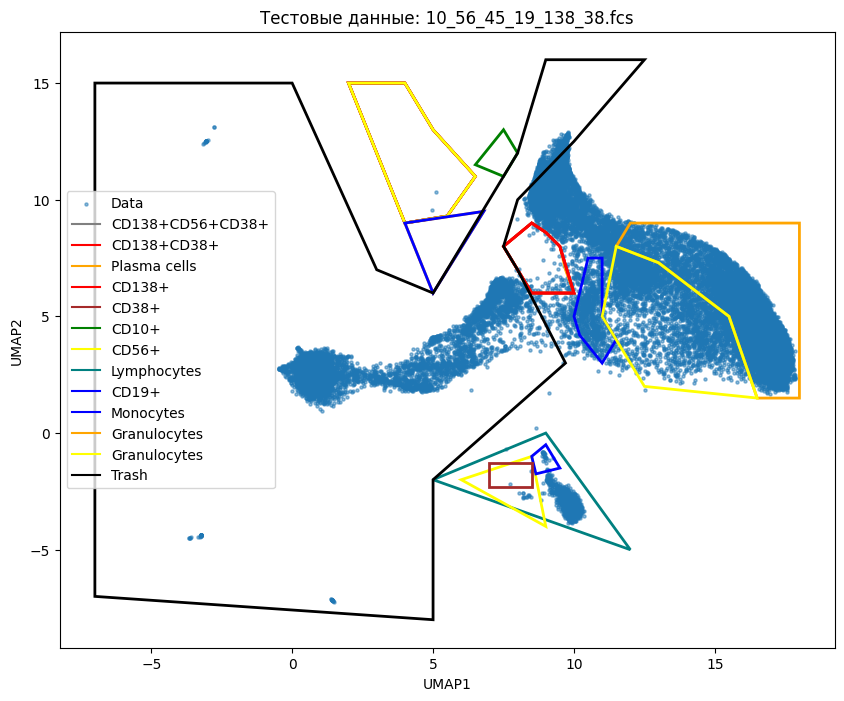

,Абс. количество,"Содержание, %"
CD138+CD56+CD38+,2,0.026300
CD138+CD38+,77,1.014000
Plasma cells,75,0.987600
CD138+,77,1.014000
CD38+,79,1.040300
CD10+,0,0.000000
CD56+,16,0.210700
Lymphocytes,705,9.283600
CD19+,29,0.381900
Monocytes,701,9.231000


Отчёт сохранён в D:\NovoExpress Data\Reports\Report_of_Мадрахимова Д.Х.csv
Mon Apr 21 21:37:12 2025 Building and compiling search function


C:\Users\vsevo\flowcytlibs\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Epochs completed:   0%|            0/30 [00:00]

	completed  0  /  30 epochs
	completed  3  /  30 epochs
	completed  6  /  30 epochs
	completed  9  /  30 epochs
	completed  12  /  30 epochs
	completed  15  /  30 epochs
	completed  18  /  30 epochs
	completed  21  /  30 epochs
	completed  24  /  30 epochs
	completed  27  /  30 epochs

Статистика для пробирки λ_κ_45_117_138_38.fcs (пациент: Мадрахимова Д.Х):


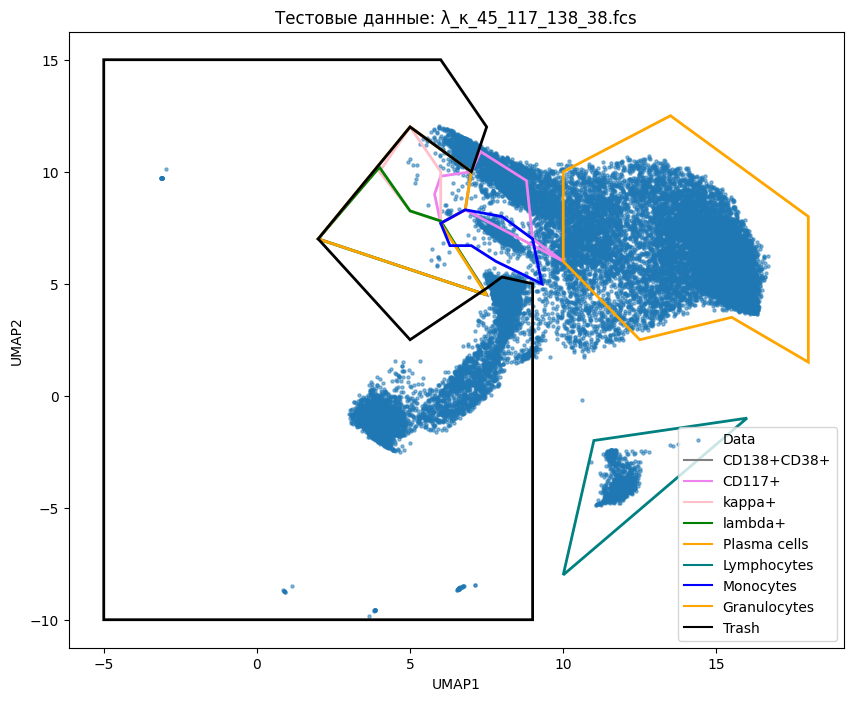

,Абс. количество,"Содержание, %"
CD138+CD38+,95,1.226800
CD117+,4145,53.525299
kappa+,9,0.116200
lambda+,11,0.142000
Plasma cells,95,1.226800
Lymphocytes,767,9.904400
Monocytes,523,6.753600
Granulocytes,13184,62.996899
Mononuclears,7744,27.969801


Отчёт сохранён в D:\NovoExpress Data\Reports\Report_of_Мадрахимова Д.Х.csv
Mon Apr 21 21:37:59 2025 Building and compiling search function


C:\Users\vsevo\flowcytlibs\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Epochs completed:   0%|            0/30 [00:00]

	completed  0  /  30 epochs
	completed  3  /  30 epochs
	completed  6  /  30 epochs
	completed  9  /  30 epochs
	completed  12  /  30 epochs
	completed  15  /  30 epochs
	completed  18  /  30 epochs
	completed  21  /  30 epochs
	completed  24  /  30 epochs
	completed  27  /  30 epochs

Статистика для пробирки xx_79a_45_Ki67_3_xx.fcs (пациент: Мадрахимова Д.Х):


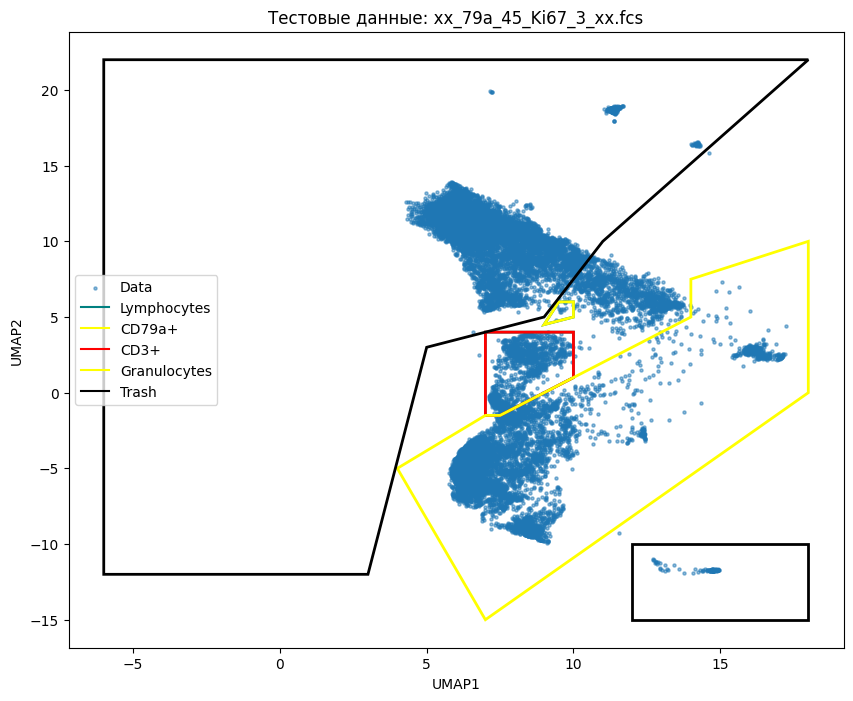

,Абс. количество,"Содержание, %"
Lymphocytes,1249,48.865398
CD79a+,13,0.508600
CD3+,1236,48.356800
Granulocytes,7261,73.963501
Mononuclears,2556,13.926100


Отчёт сохранён в D:\NovoExpress Data\Reports\Report_of_Мадрахимова Д.Х.csv
Отчёт сохранён в D:\NovoExpress Data\Reports\Report of Мадрахимова Д.Х.pdf
Удалена папка: D:\NovoExpress Data\Мадрахимова Д.Х

Обрабатываю папку: Первушин Ю.Е
Mon Apr 21 21:38:32 2025 Building and compiling search function


C:\Users\vsevo\flowcytlibs\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Epochs completed:   0%|            0/30 [00:00]

	completed  0  /  30 epochs
	completed  3  /  30 epochs
	completed  6  /  30 epochs
	completed  9  /  30 epochs
	completed  12  /  30 epochs
	completed  15  /  30 epochs
	completed  18  /  30 epochs
	completed  21  /  30 epochs
	completed  24  /  30 epochs
	completed  27  /  30 epochs

Статистика для пробирки 10_56_45_19_138_38.fcs (пациент: Первушин Ю.Е):


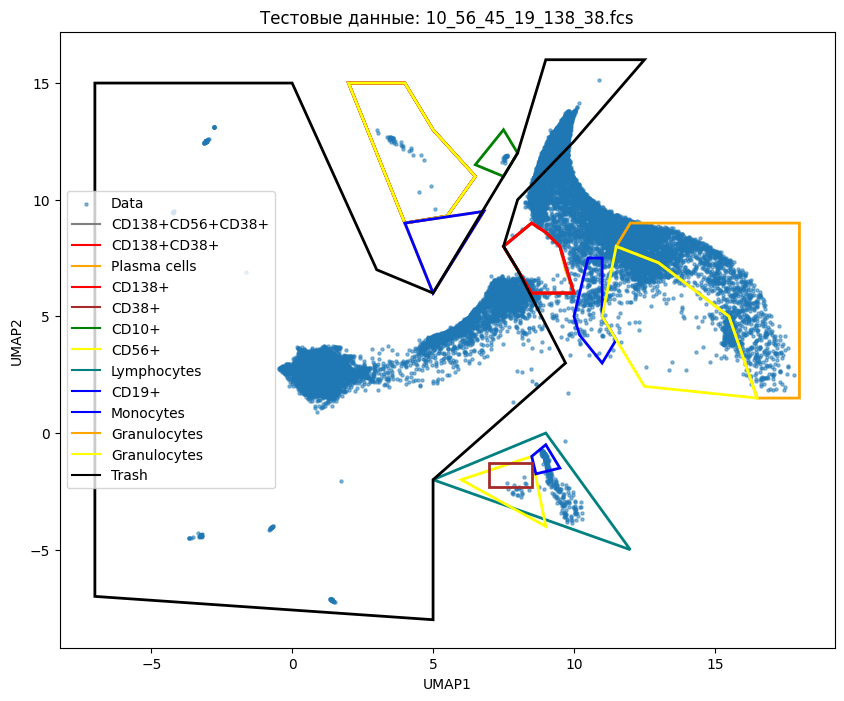

,Абс. количество,"Содержание, %"
CD138+CD56+CD38+,34,0.491300
CD138+CD38+,116,1.676300
Plasma cells,80,1.156100
CD138+,116,1.676300
CD38+,121,1.748600
CD10+,18,0.260100
CD56+,55,0.794800
Lymphocytes,425,6.141600
CD19+,258,3.728300
Monocytes,201,2.904600


Отчёт сохранён в D:\NovoExpress Data\Reports\Report_of_Первушин Ю.Е.csv
Mon Apr 21 21:39:09 2025 Building and compiling search function


C:\Users\vsevo\flowcytlibs\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Epochs completed:   0%|            0/30 [00:00]

	completed  0  /  30 epochs
	completed  3  /  30 epochs
	completed  6  /  30 epochs
	completed  9  /  30 epochs
	completed  12  /  30 epochs
	completed  15  /  30 epochs
	completed  18  /  30 epochs
	completed  21  /  30 epochs
	completed  24  /  30 epochs
	completed  27  /  30 epochs

Статистика для пробирки λ_κ_45_117_138_38.fcs (пациент: Первушин Ю.Е):


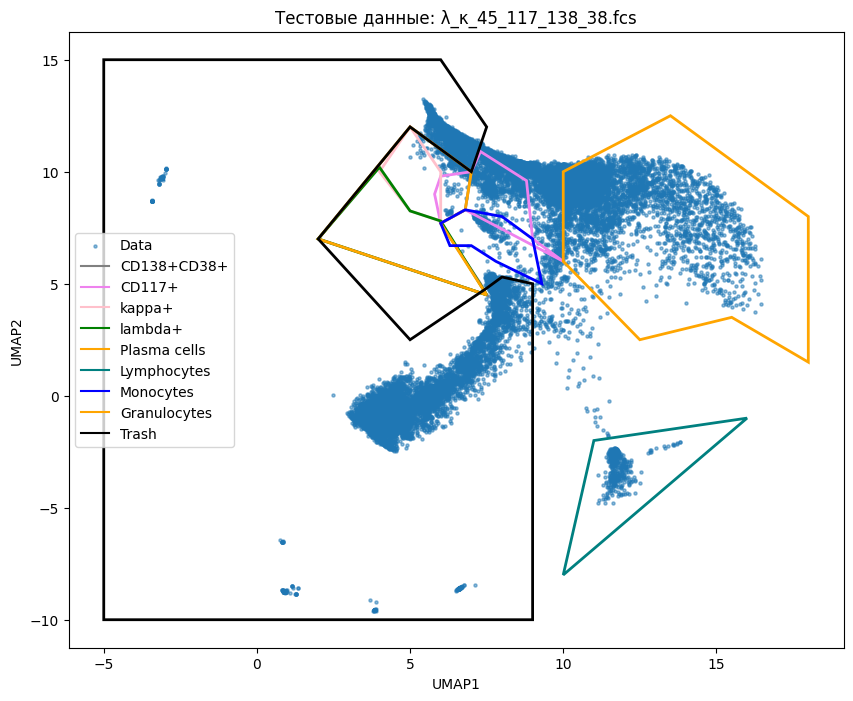

,Абс. количество,"Содержание, %"
CD138+CD38+,288,5.402400
CD117+,945,17.726500
kappa+,12,0.225100
lambda+,0,0.000000
Plasma cells,288,5.402400
Lymphocytes,454,8.516200
Monocytes,204,3.826700
Granulocytes,4642,46.545700
Mononuclears,5331,24.780399


Отчёт сохранён в D:\NovoExpress Data\Reports\Report_of_Первушин Ю.Е.csv
Mon Apr 21 21:39:46 2025 Building and compiling search function


C:\Users\vsevo\flowcytlibs\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Epochs completed:   0%|            0/30 [00:00]

	completed  0  /  30 epochs
	completed  3  /  30 epochs
	completed  6  /  30 epochs
	completed  9  /  30 epochs
	completed  12  /  30 epochs
	completed  15  /  30 epochs
	completed  18  /  30 epochs
	completed  21  /  30 epochs
	completed  24  /  30 epochs
	completed  27  /  30 epochs

Статистика для пробирки xx_79a_45_Ki67_3_xx.fcs (пациент: Первушин Ю.Е):


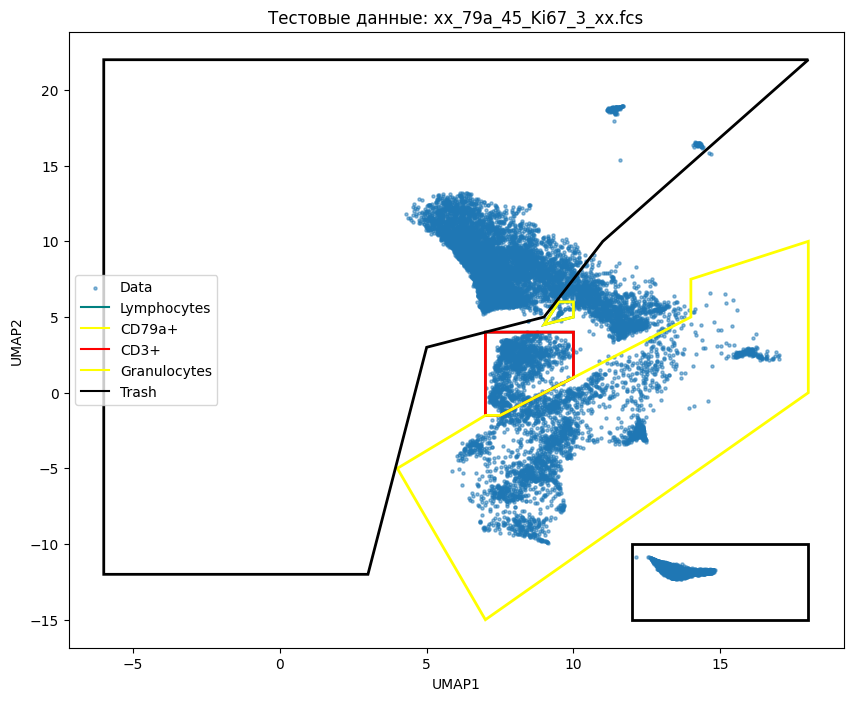

,Абс. количество,"Содержание, %"
Lymphocytes,1346,48.399899
CD79a+,33,1.186600
CD3+,1313,47.213200
Granulocytes,2712,49.371899
Mononuclears,2781,18.557301


Отчёт сохранён в D:\NovoExpress Data\Reports\Report_of_Первушин Ю.Е.csv
Отчёт сохранён в D:\NovoExpress Data\Reports\Report of Первушин Ю.Е.pdf
Удалена папка: D:\NovoExpress Data\Первушин Ю.Е
CPU times: total: 9min
Wall time: 9min 14s


In [7]:
%%time
process_test_data(path, tube, pdf=True, fcs_del=True)  # fcs_del=False, и .fcs останется

In [8]:
%%time
make_report(path,  # Корневая папка, в которой лежит папка Reports с новыми отчётами.
            blanks=r'C:\Users\vsevo\Downloads',  # Папка с заключениями 
            coordinates=r'D:\NovoExpress Data\Examples\Saved_UMAP_n_csv',  # Координаты для связи репорта и бланка заключения
            image_folder=r'D:\NovoExpress Data\Examples\Saved_UMAP_n_csv\media',  # Оформление для бланка
            clean=True)  # Если True (по умолчанию), отчётные файлы будут удалены. False - не будут удалены

CPU times: total: 46.9 ms
Wall time: 67.5 ms
